# Import Modules

In [1]:
import scanpy as sc
import squidpy as sq
import sys
sys.path.append(r"/home/yqzhou/JUPYTER/MyPackage/Pianno")
import pianno as po
import json
from os.path import join

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
sample_name = "PDAC-B"

In [4]:
config_path = "/home/yqzhou/JUPYTER/Revision/Q1/" + sample_name

# Step1：Create Mask Image

In [5]:
data_path = join(config_path, "pianno_adata.h5ad")
adata = sc.read(data_path)

In [6]:
adata

AnnData object with n_obs × n_vars = 224 × 4608
    obs: 'array_row', 'array_col', 'SizeFactor', 'spotID'
    var: 'mt', 'n_cells'
    uns: 'Mask', 'moranI', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'DenoisedX', 'RawX'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Step2：Initial Pattern Recognition

In [51]:
Patterndict = dict(Duct = ["MUC5B"],
                   Cancer = ["MUC4"],
                   Stroma = [])

Configuration path of Pianno: /home/yqzhou/JUPYTER/Revision/Q1/PDAC-B
[2023-12-24 15:38:39] Creating experiment, Experiment ID: 6kpu0cjy
[2023-12-24 15:38:39] Starting web server...
[2023-12-24 15:38:40] Setting up...
[2023-12-24 15:38:40] Web UI URLs: http://127.0.0.1:8080 http://10.10.10.18:8080 http://11.11.11.18:8080
[2023-12-24 15:41:32] KeyboardInterrupt detected
[2023-12-24 15:41:32] Stopping experiment, please wait...
[2023-12-24 15:41:35] Experiment stopped


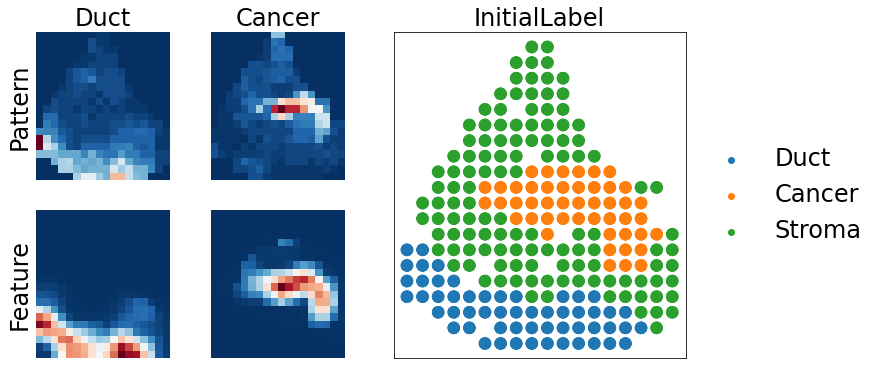

In [52]:
adata = po.AutoPatternRecognition(adata,
                                  Patterndict=Patterndict,
                                  config_path=config_path,
                                  param_tuning=True,
                                  max_experiment_duration='10m')

In [53]:
with open(join(config_path, "best_params.json"),'r') as f:
    best_params_dict = json.load(f)
best_params_dict

{'0.0': {'n_class': 2,
  'dilation_radius': 5.0,
  'denoise_weight': 0.02,
  'unsharp_radius': 3.0,
  'unsharp_amount': 13.0,
  'gaussian_blur': 4.0}}

# Step3：Marker Selection

In [54]:
ProposedPatterndict = po.ProposedPatterndict(adata, top_n=10)

Duct
['SPINK1', 'MUC5B', 'SERPINA1', 'CRP', 'CFB', 'MUC1', 'PRSS8', 'LCN2', 'SCGB3A1', 'TFF3']


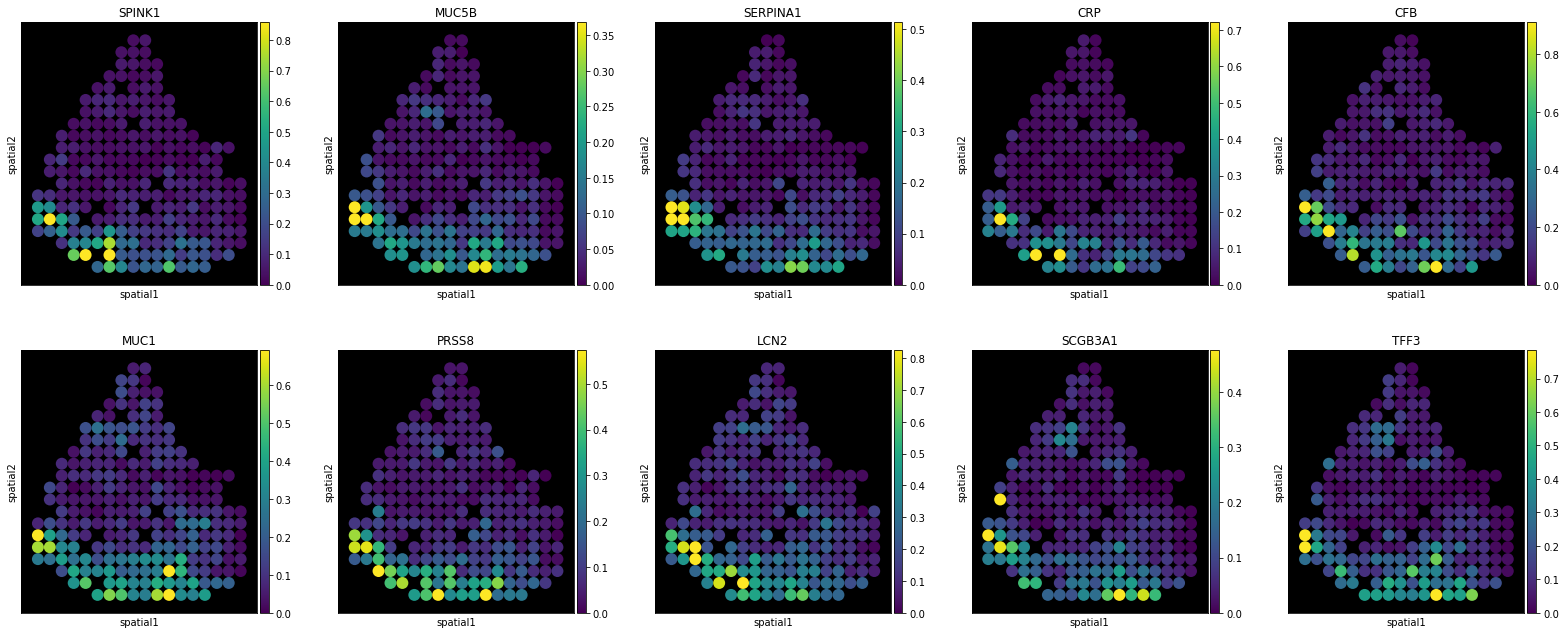

Cancer
['ZNF839', 'XRCC1', 'PABPC1L', 'SF3B1', 'PPP1R35', 'MMP11', 'CDKN2A', 'AP1G2', 'MUC4', 'VMP1']


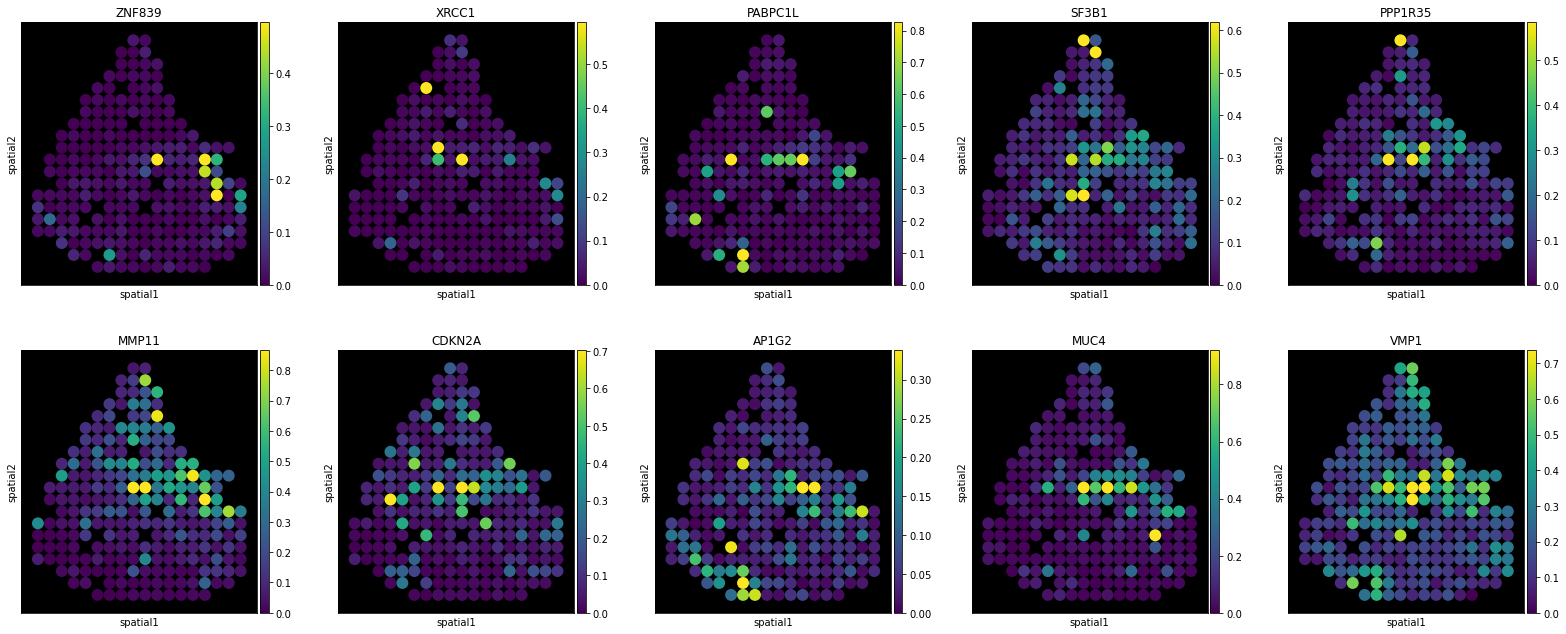

Stroma
['THBS1', 'GXYLT2', 'NPTX1', 'EPHX2', 'OSTC', 'CFD', 'FCGR1A', 'SLC29A3', 'DOK3', 'CHAMP1']


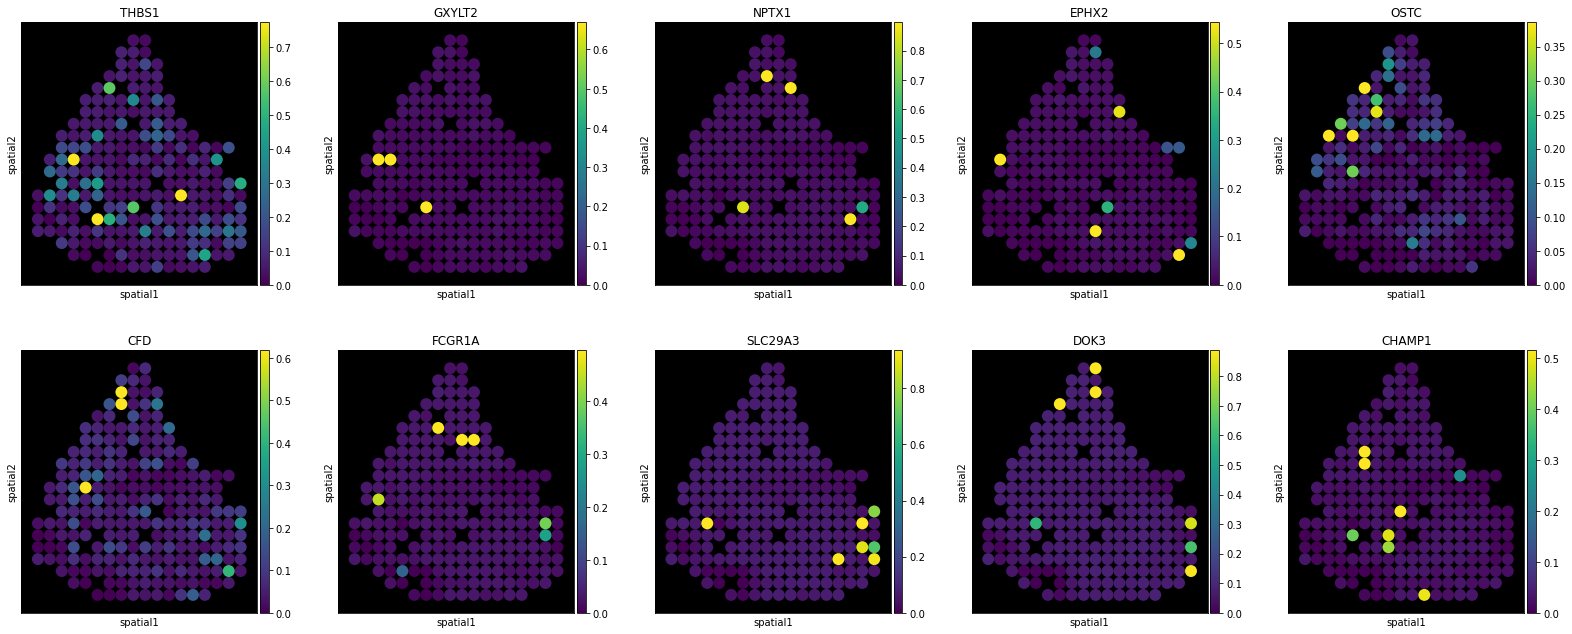

In [55]:
# plot in spatial coordinates
for k, v in ProposedPatterndict.items():
    print(k)
    print(v)
    with mpl.rc_context({'axes.facecolor':  'black',
                         'figure.figsize': [4.5, 5]}):
        sc.pl.spatial(adata, #cmap='magma',
                      layer='DenoisedX',
                      color=v,
                      ncols=5, size=1,
                      spot_size=1,
                      vmin=0, vmax='p99'
                     )

# Step4：Renewed Pattern Recognition

In [14]:
Patterndict = dict(Duct = ["MUC5B", 'CFB', 'PRSS8'],
                   Cancer = ["MUC4", 'MMP11', 'SF3B1'],
                   Stroma = [])

In [15]:
with open(config_path+"/marker_list.json","w") as f:
    json.dump(Patterndict, f, indent=4, ensure_ascii=False)

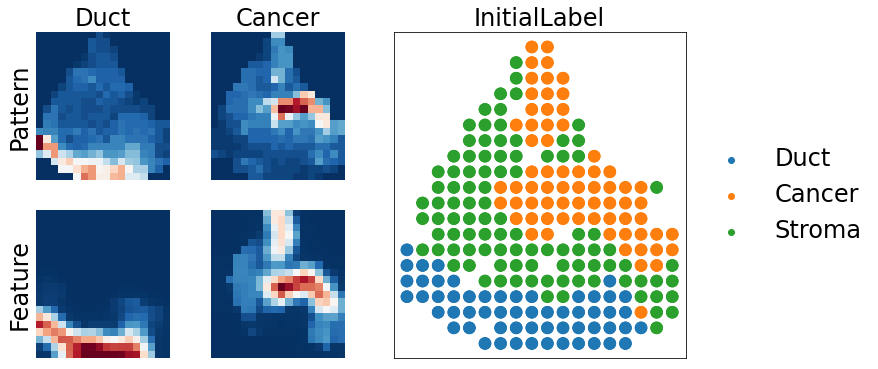

In [16]:
adata = po.AutoPatternRecognition(adata,
                                  Patterndict=Patterndict,
                                  config_path=config_path,
                                  param_tuning=False)

# Step5：Annotation Improvement

---Create Spatial Graph: Done!
---Compute Spatial Energy: Done!
---Find K-Nearest Neighbor in UMAP: Done!
---Compute KNN Energy: Done!
---Compute Global Energy: Done!
Elapsed time: 0.699s
log-likelihood: -3486.0503174212845
Elapsed time: 5.680s


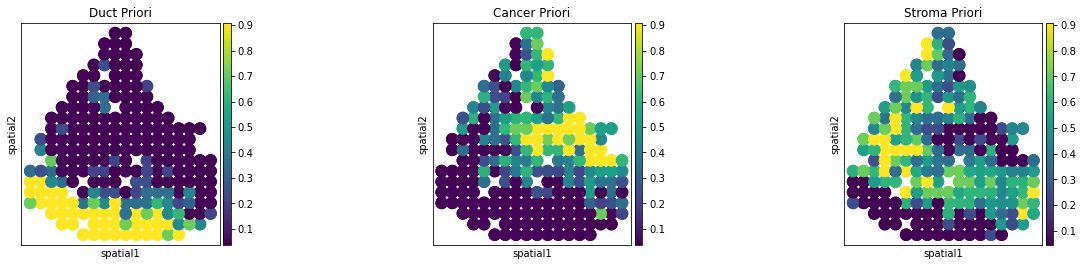

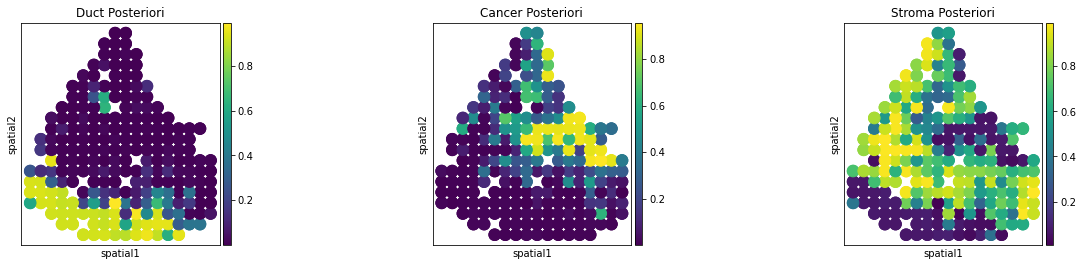

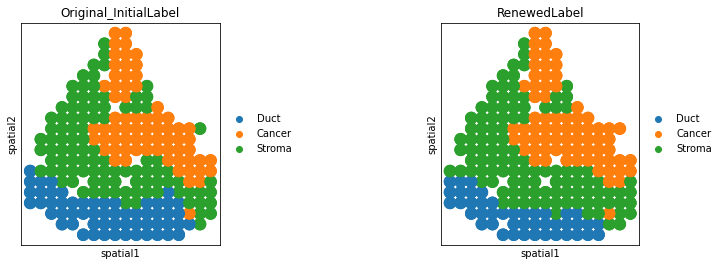

In [17]:
adata = po.AnnotationImprovement(adata,
                                 omegaK=0.99, 
                                 omegaG=0.01,
                                 small_objects=0,
                                 keep_region=['Cancer'],
                                 blur_deviation=1, 
                                 denoise_weight=0.01)

In [18]:
adata.write_h5ad(join(config_path, "pianno_adata.h5ad"))